In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

In [3]:
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.nn import GCNConv, Set2Set, GNNExplainer
import torch_geometric.transforms as T
import torch
import torch.nn.functional as F
import os

import matplotlib.pyplot as plt
from dgl.data import BACommunityDataset
import networkx as nx
import torch_geometric
import dgl


In [35]:
from src.model import *
from src.data import *
from src.explainer import *
from src.plot import *
from src.modify import *
from src.protgnn import *

C:\Users\Yurt\Documents\Cambridge\GNN\gnn_explainability


In [5]:
cora_dataset = get_cora_dataset()

In [6]:
ba_dataset = get_dataset("BAShapes")

Done loading data from cached files.


C:\Users\Yurt\anaconda3\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [7]:
num_classes = len(set([int(i) for i in ba_dataset.y]))
num_features = ba_dataset.x.shape[-1]

In [8]:
epochs = 200
dim = 16

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(num_features=num_features, dim=dim, num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)


In [10]:
num_classes, num_features

(4, 1)

In [11]:
cora_dataset.x.shape

torch.Size([2708, 1433])

In [12]:
model = train_model(epochs,model,device,ba_dataset,optimizer,test_model)

[Train_loss:0.972507 Train_acc: 0.6679, Test_acc: 0.8571]: 100%|████████████████████| 200/200 [00:01<00:00, 174.05it/s]


In [13]:
num_classes = len(set([int(i) for i in cora_dataset.y]))
num_features = cora_dataset.x.shape[-1]

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(num_features=num_features, dim=dim, num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)


In [15]:
model = train_model(epochs,model,device,cora_dataset,optimizer,test_model)

[Train_loss:1.579114 Train_acc: 0.4286, Test_acc: 0.4400]: 100%|█████████████████████| 200/200 [00:03<00:00, 63.98it/s]


In [16]:
explainer = GNNExplainer(model, epochs=200)

TypeError: __init__() got multiple values for argument 'epochs'

In [ ]:
node_feature_mask, edge_mask = explain_model(explainer,cora_dataset,10)

In [18]:
gce_explainer = GCExplainer()

In [19]:
gce_explainer.learn_prototypes(model,cora_dataset)

In [20]:
gce_explainer.get_prediction(model,cora_dataset)

array([3, 1, 3, ..., 0, 3, 3], dtype=int64)

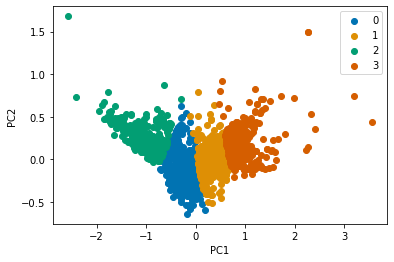

In [21]:
plot_kmeans_clusters(gce_explainer.kmeans,gce_explainer.initial_activations)

In [22]:
gce_explainer.get_prediction(model,identity(cora_dataset))

array([3, 1, 3, ..., 0, 3, 3], dtype=int64)

In [ ]:
model = GCNNet_NC(num_features, num_classes, model_args)

In [ ]:
cora_dataset.test_mask

In [ ]:
model = train_model(epochs,model,device,cora_dataset,optimizer,test_model,protgnn=True)

In [ ]:
prot_explainer = ProtGNNExplainer()

In [ ]:
prot_explainer.learn_prototypes(model,cora_dataset)

In [ ]:
prot_explainer.get_prediction(model,cora_dataset)

In [26]:
### not quite sure how to integrate this part

global activation_list
activation_list = {}

def register_hooks(model):
    for name, m in model.named_modules():
            if isinstance(m, GCNConv):
                m.register_forward_hook(get_activation(f"{name}"))

    return model


def get_activation(idx):
    def hook(model, in_put, output):
        if idx == "diff_pool":
            ret_labels = ["pooled_node_feat_matrix", "coarse_adj", "link_pred_loss", "entropy_reg"]
            for l, t in zip(ret_labels, output):
                activation_list[f"{idx}_{l}"] = t.detach()
        else:
            activation_list[idx] = output.detach()
    return hook

In [27]:
model = GCN(num_features=num_features, dim=dim, num_classes=num_classes).to(device)

In [ ]:
# register hooks to track activation
model = register_hooks(model)

In [28]:
train_model(epochs,model,device,cora_dataset,optimizer,test_model,if_interpretable_model=True)

[Train_loss:0.050697 Train_acc: 0.0738, Test_acc: 0.0660]: 100%|█████████████████████| 200/200 [00:06<00:00, 29.97it/s]


GCN(
  (conv0): GCNConv(1433, 16)
  (conv1): GCNConv(16, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 16)
  (lens): Sequential(
    (0): EntropyLinear(
      in_features=16, out_features=1, n_classes=7
      (conceptizator): Conceptizator(activation=identity_bool, threshold=0.5)
    )
  )
)

In [36]:
cdm_explainer = CDMExplainer()